# Week 5 - Semantic & Influence Networks

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git

#All these packages need to be installed from pip

#This will be doing most of the work
import networkx as nx

import sklearn #For generating some matrices
import pandas #For DataFrames
import numpy as np #For arrays
import matplotlib.pyplot as plt #For plotting
import seaborn #Makes the plots look nice
import scipy #Some stats
import nltk #a little language code
from IPython.display import Image #for pics

import pickle #if you want to save layouts
import os

%matplotlib inline

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that render networks to meaningfully characterize the structure of words and documents (or subdocuments like chapters or paragraphs) from your corpus. What are useful filters and thresholds and what semantic structures do they reveal that give insight into the social world and social game inscribed in your corpus? Interrogate interesting subgraphs of your network and detail what they reveal about the semantic space involved.

In [2]:
commentsPosDF = pandas.read_csv('comments_positive.csv', nrows=5000)
commentsPosDF.head()

,id,parent_id,subreddit_id,link_id,text,score,ups,author,controversiality,parent_link_id,parent_text,parent_score,parent_ups,parent_author,parent_controversiality
0,c092j8m,t1_c092gss,t5_2qh2p,t3_8eyy3,This isn't Twitter: try to comment on the arti...,9582,9582,nraustinii,0,t3_8eyy3,Fucking faggot.,-7526,-7526,Glorificus,0
1,c4imcva,t1_c4im948,t5_2qh1i,t3_t0ynr,"Well, it is exactly what it sounds like. It's ...",9531,9531,Lynfect,0,t3_t0ynr,"Elaborate on this cum box, please.",3841,3841,eeeeevil,0
2,c0s4nfi,t1_c0s4lje,t5_2qh1i,t3_cf1n2,"In soviet Russia, bomb disarms you!",8545,8545,CapnScumbone,0,t3_cf1n2,"I don't live in Russia anymore, and I will not...",621,621,shady8x,0
3,c4ini33,t1_c4incln,t5_2qh1i,t3_t0ynr,"""runin for senitur! #YOLO!""",7430,7430,[deleted],0,t3_t0ynr,This just made me realize that future presiden...,4651,4651,drspg99,0
4,c4imgel,t1_c4ima2e,t5_2qh1i,t3_t0ynr,You step motherfucker.,7173,7173,jbg89,0,t3_t0ynr,I have sex with my step mom when my dad isn't ...,4251,4251,audir8,0


In [3]:
commentsPosDF['tokenized_sents'] = commentsPosDF['text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
commentsPosDF['normalized_sents'] = commentsPosDF['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])

In [4]:
from nltk.corpus import stopwords
stopWords = set(stopwords.words('english'))

def wordCooccurrence(sentences, makeMatrix = False):
    words = set()
    for sent in sentences:
        union = set(sent) | stopWords
        intersection = set(sent) & stopWords
        words |= (union - intersection)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in sentences:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        return g

In [5]:
def tokenize(text):
    tokenlist = lucem_illud_2020.word_tokenize(text)
    normalized = lucem_illud_2020.normalizeTokens(tokenlist)
    return normalized

In [6]:
import sklearn.feature_extraction

In [7]:
comVectorizer = sklearn.feature_extraction.text.CountVectorizer(tokenizer = tokenize)
comVects_incidence = comVectorizer.fit_transform(commentsPosDF['text'])

In [8]:
comVects_incidence.shape

(5000, 13140)

In [9]:
g_2mode = nx.Graph()

#define all the nodes
g_2mode.add_nodes_from((comVectorizer.get_feature_names()[i] for i in range(comVects_incidence.shape[1])), bipartite = 'word')
g_2mode.add_nodes_from(range(comVects_incidence.shape[0]), bipartite = 'doc')

#add all the edges
g_2mode.add_edges_from(((d, comVectorizer.get_feature_names()[w], {'weight' : comVects_incidence[d, w]}) for d, w in zip(*comVects_incidence.nonzero())))

In [10]:
print(nx.info(g_2mode))

Name: 
Type: Graph
Number of nodes: 18140
Number of edges: 66913
Average degree:   7.3774


In [11]:
def contractNetwork(g, targetType):
    g_mono = nx.Graph()
    g_mono.add_nodes_from(((n, d) for n, d in g_2mode.nodes(data = True) if d['bipartite'] == targetType))
    
    for n_outside in (n for n, d in g_2mode.nodes(data = True) if d['bipartite'] != targetType):
        neighbors = list((n for n in g.neighbors(n_outside) if g.nodes[n]['bipartite'] == targetType))
        for i, n1 in enumerate(neighbors):
            for n2 in neighbors[i+1:]:
                try:
                    g_mono.edges[n1, n2]['weight'] += 1
                except KeyError:
                    g_mono.add_edge(n1, n2, weight = 1)
    return g_mono

In [12]:
gDoc = contractNetwork(g_2mode, 'doc')

In [13]:
print(nx.info(gDoc))

Name: 
Type: Graph
Number of nodes: 5000
Number of edges: 1413245
Average degree: 565.2980


In [15]:
gWord = contractNetwork(g_2mode, 'word')
print(nx.info(gWord))

Name: 
Type: Graph
Number of nodes: 13140
Number of edges: 2038707
Average degree: 310.3055


In [16]:
wMean = np.mean([d['weight'] for n1, n2, d in gWord.edges(data = True)])
wMean

1.3816021625471437

In [18]:
g = wordCooccurrence(commentsPosDF['normalized_sents'][:].sum())

In [19]:
len(g.nodes)

13344

In [20]:
len(g.edges)

211597

In [21]:
g.remove_edges_from([(n1, n2) for n1, n2, d in g.edges(data = True) if d['weight'] <= 7])

In [22]:
g.remove_nodes_from(list(nx.isolates(g)))

In [23]:
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

In [24]:
giant = max(connected_component_subgraphs(g), key=len) # keep just the giant connected component
print(nx.info(giant))

Name: 
Type: Graph
Number of nodes: 274
Number of edges: 940
Average degree:   6.8613


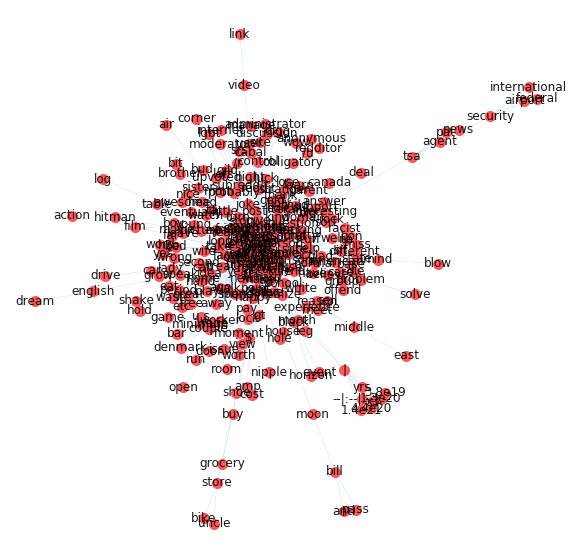

In [25]:
layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

In [26]:
from networkx.algorithms.community import greedy_modularity_communities
c = list(greedy_modularity_communities(giant))

In [27]:
c

[frozenset({'$',
            '--|:--|:--|:--',
            '/r',
            '/u',
            '1.3e20',
            '1.4e21',
            '3.8e19',
            '4.4e20',
            'act',
            'action',
            'actually',
            'administrator',
            'ago',
            'air',
            'american',
            'amp',
            'anonymous',
            'answer',
            'anti',
            'ask',
            'away',
            'awesome',
            'bad',
            'bar',
            'base',
            'bed',
            'believe',
            'big',
            'bike',
            'bill',
            'bit',
            'black',
            'blow',
            'boy',
            'brother',
            'bud',
            'buy',
            'cabal',
            'call',
            'canada',
            'car',
            'care',
            'child',
            'come',
            'comment',
            'control',
            'corner',
            'co

In [28]:
giant = nx.Graph(giant)

In [29]:
giant.remove_nodes_from([n for n in giant.nodes if len(set(giant.neighbors(n))) >= 2000]) 
giant.remove_nodes_from(list(nx.isolates(giant)))
print(nx.info(giant))

Name: 
Type: Graph
Number of nodes: 274
Number of edges: 940
Average degree:   6.8613


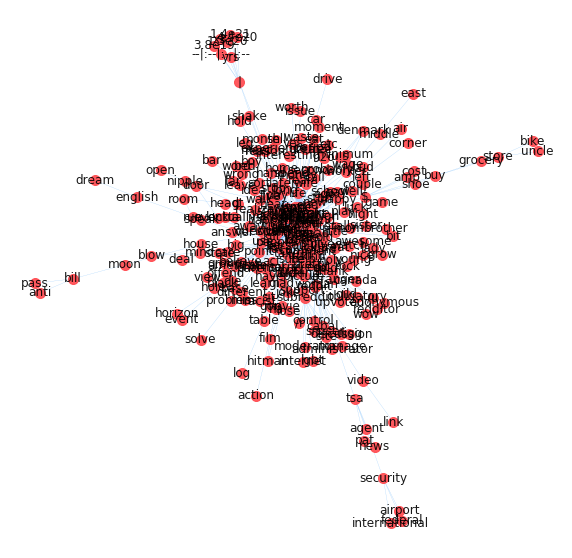

In [30]:
layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

In [31]:
print(', '.join(max(nx.clique.find_cliques(giant), key = lambda x: len(x))))

like, people, think, time, know, good, go, get, come, work, tell, want, m, day


In [37]:
feelNeighbors = giant.neighbors('feel')
g_feel = giant.subgraph(feelNeighbors)
print(nx.info(g_feel))

Name: 
Type: Graph
Number of nodes: 19
Number of edges: 106
Average degree:  11.1579


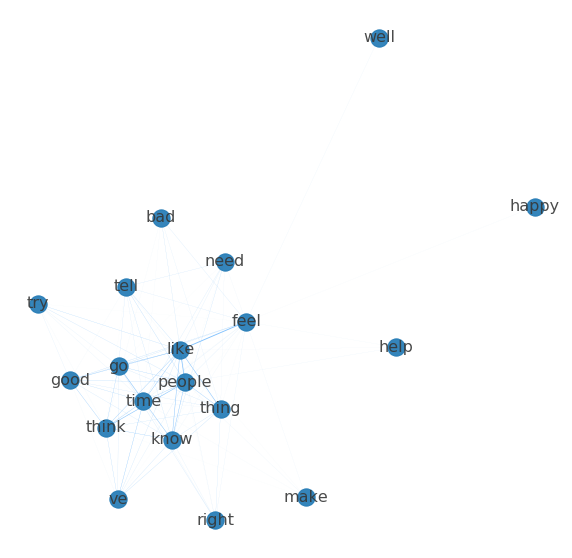

In [38]:
layout_amer = nx.spring_layout(g_feel, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
maxWeight = max((d['weight'] for n1, n2, d in g_feel.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_feel.edges(data = True)))
nx.draw(g_white, ax = ax, pos = layout_amer, labels = {n:n for n in g_feel.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_feel.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma')) 

In [43]:
whiteNeighbors = gWord.neighbors('white')
whiteNeighborsPlus1 = set(whiteNeighbors)
for n in whiteNeighbors:
    whiteNeighborsPlus1 |= set(giant.neighbors(n))
    
for x in whiteNeighborsPlus1:
    print(x)

test
age
qui
vein
policy
replace
avast
swallow
face
lanky
response
deploy
silence
cheesecloth
effective
athelete
gas
defiant
stéphane
murder
porno
acte
deeply
13:44
terp
mourn
flying
routine
5:39
social
killer
prop
receipt
impossible
fretful
maintain
c+/b-
pretend
elation
killing
silly
hotness
wait
hate
ethically
journalist
support
show
deer
peek
continent
god
category
place
intense
grin
greasy
gt
french
demonstration
finally
delirium
mind
distance
leather
september
hug
sharpen
eviscerate
+
tomorrow
sure
highway
summon
doorbell
adept
busy
flight
behave
celebration
implicit
sad
crumple
supervision
adminsitrator
90
court
idea
mix
waitress
momentum
armed
https://www.youtube.com/watch?v=zuwuaxd-190
serve
bleed
comply
innocent
book
upper
paris
spread
socially
attempt
imma
send
mistake
literally
brow
rip
weigh
prepping
interested
lesson
loosen
layperson
cloud
pm
fuckslave
direct
unavoidable
belief
tonight
teach
prosecutor
base
aucun
manhatten
blend
provide
suffer
suspect
word
government
regi

distribute
psyche
rover
tiny
performance
national
spontaneous
magenta
cellophane
march
minimum
revenge
agape
meaning
gender
proud
require
care
oppression
deceive
volcano
tricky
advise-
nudity
cheapen
reaction
teacher
affleck
near
whirring
edible
explain
fry
name
profusely
defender
force
empower
pull
crt
carefully
doggy
18:00
soul
weekend
roommate
handed
nonsense
forgive
include
human
tree
kill
weak
spray
line
gain
build
stick
helium
site
fetid
yard
squeeze
pas
attendant
emotional
trade
mistaken
well
conquer
gate
poo](http://i.imgur.com
fascinate
reclusive
strong
indispensable
horrify
apparently
behaviour
faux
sprawl
tv
personal
xp
have
bounce
boom
english
gobbler
edit2
heavens
inside
stylie
allow
characteristics)is
someone
hater
creative
sorry
unite
taste
gold
viewer
style
rind
shady
college
bother
worth
resistance
make
set
swinging
available
scared
pound
tell
regenerative
easily
hiking
leave
like
public
14:26
secretary
sky
grip
unspoken
home
helpless
blow
transcript
crazy
gear
rejecti

In [45]:
g_white = giant.subgraph(whiteNeighborsPlus1)
print(nx.info(g_white))

Name: 
Type: Graph
Number of nodes: 217
Number of edges: 831
Average degree:   7.6590


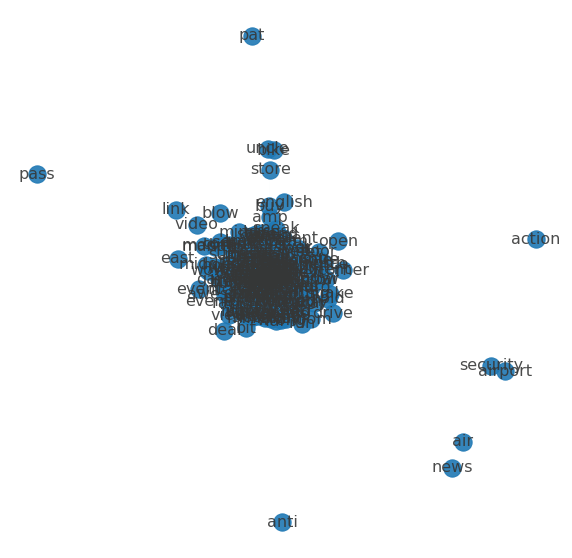

In [46]:
layout_amer = nx.spring_layout(g_white, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
centralities_amer = nx.eigenvector_centrality(g_white)
maxC = max(centralities_amer.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in g_white.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_white.edges(data = True)))
nx.draw(g_white2, ax = ax, pos = layout_amer, labels = {n:n for n in g_white.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_white.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma')) 

My dataset consists of 5000 comments that received the highest upvotes in the Reddit community. Through analyzing the structure of words, I find that dropping all the edges below certain weight and all the isolates can produce more interpretable semantic structures. The core cliques in our dataset include like, people, think, time, know, good, go, get, come, work, tell, and want... These all suggest people-related actions and events. Our exploratory analysis reveal that comments that received the most upvotes are mostly around stories about people.

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that calculate different kinds of centrality for distinct words or documents in a network composed from your corpus of interest. Which type of words tend to be most and least central? Can you identify how different centrality measures distinguish different kind of words in your corpus? What do these patterns suggest about the semantic content and structure of your documents? Finally, calculate global measure for your network(s) and discuss what they reveal.

### Measure of Centrality

In [47]:
dcentralities = nx.degree_centrality(giant)

In [51]:
dcentralities['like']

0.30036630036630035

In [52]:
max(dcentralities.items(), key = lambda x : x[1])

('like', 0.30036630036630035)

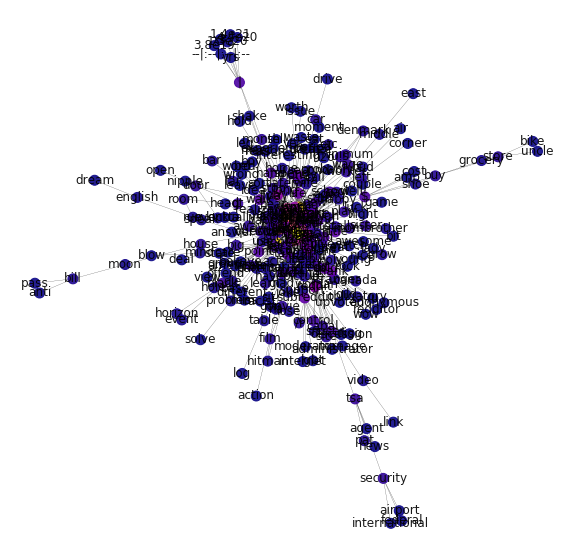

In [53]:
# betweenness centrality
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(dcentralities.items(), key = lambda x : x[1])[1]
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = [dcentralities[n] / maxC for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

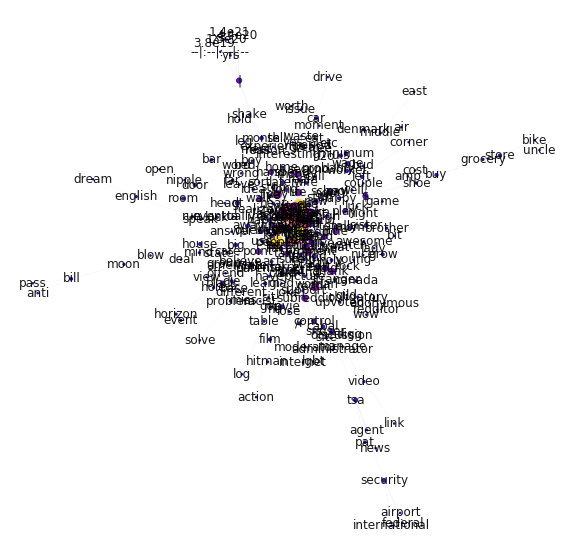

In [54]:
# degree centrality and edge weight
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(dcentralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gWord.edges(data = True)], 
        alpha = .9, 
        node_color = [dcentralities[n] / maxC for n in giant.nodes],
        node_size = [dcentralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

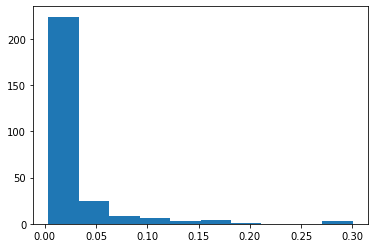

In [55]:
plt.hist(list(dcentralities.values()))
plt.show()

In [56]:
# top 10 words
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('like', 0.30036630036630035),
 ('people', 0.2783882783882784),
 ('time', 0.27472527472527475),
 ('go', 0.20146520146520147),
 ('m', 0.1794871794871795),
 ('know', 0.1684981684981685),
 ('think', 0.16483516483516483),
 ('get', 0.16117216117216118),
 ('good', 0.14285714285714285),
 ('want', 0.13553113553113552)]

In [57]:
# bottom 10 words
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('interesting', 0.003663003663003663),
 ('cost', 0.003663003663003663),
 ('period', 0.003663003663003663),
 ('bit', 0.003663003663003663),
 ('care', 0.003663003663003663),
 ('worth', 0.003663003663003663),
 ('deal', 0.003663003663003663),
 ('log', 0.003663003663003663),
 ('solve', 0.003663003663003663),
 ('group', 0.003663003663003663)]

### Betweenness Centrality

In [58]:
centralities = nx.betweenness.betweenness_centrality(giant)

In [65]:
centralities['people']

0.21946457516413864

In [66]:
max(centralities.items(), key = lambda x : x[1])

('like', 0.2246044941269925)

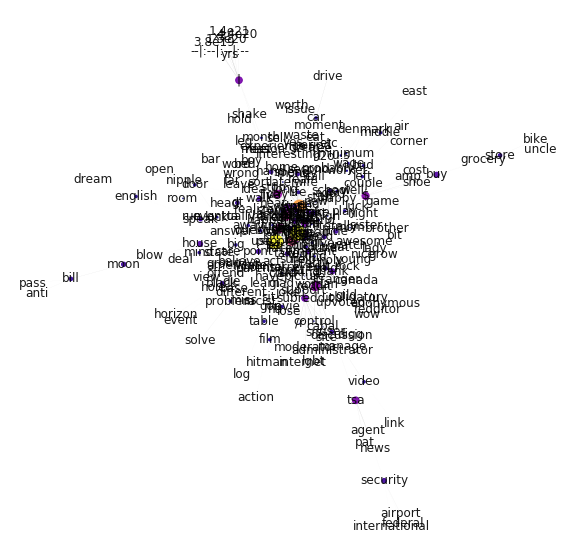

In [67]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

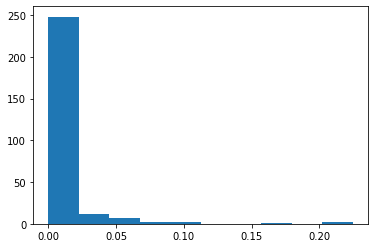

In [68]:
plt.hist(list(centralities.values()))
plt.show()

In [69]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('like', 0.30036630036630035),
 ('people', 0.2783882783882784),
 ('time', 0.27472527472527475),
 ('go', 0.20146520146520147),
 ('m', 0.1794871794871795),
 ('know', 0.1684981684981685),
 ('think', 0.16483516483516483),
 ('get', 0.16117216117216118),
 ('good', 0.14285714285714285),
 ('want', 0.13553113553113552)]

In [70]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[50:60]

[('job', 0.03296703296703297),
 ('make', 0.03296703296703297),
 ('girl', 0.03296703296703297),
 ('school', 0.03296703296703297),
 ('edit', 0.03296703296703297),
 ('new', 0.03296703296703297),
 ('control', 0.029304029304029304),
 ('black', 0.029304029304029304),
 ('user', 0.029304029304029304),
 ('person', 0.029304029304029304)]

### Closeness Centrality

In [71]:
centralities = nx.closeness_centrality(giant)

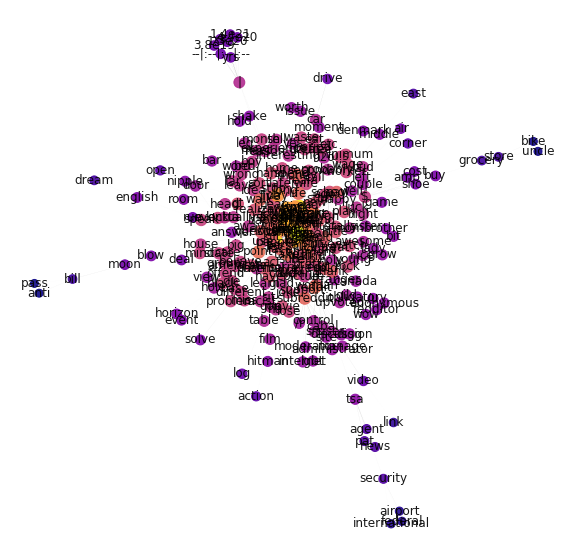

In [72]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

In [73]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('like', 0.5112359550561798),
 ('time', 0.48663101604278075),
 ('people', 0.48576512455516013),
 ('go', 0.4642857142857143),
 ('know', 0.45652173913043476),
 ('m', 0.4497528830313015),
 ('get', 0.4482758620689655),
 ('good', 0.4453507340946166),
 ('think', 0.4431818181818182),
 ('want', 0.4431818181818182)]

In [74]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('grocery', 0.19811320754716982),
 ('bill', 0.19402985074626866),
 ('link', 0.18546195652173914),
 ('international', 0.17388535031847133),
 ('federal', 0.17388535031847133),
 ('airport', 0.17388535031847133),
 ('uncle', 0.16565533980582525),
 ('bike', 0.16565533980582525),
 ('pass', 0.16259678379988088),
 ('anti', 0.16259678379988088)]

### Eigenvector Centrality

In [75]:
centralities = nx.eigenvector_centrality(giant)

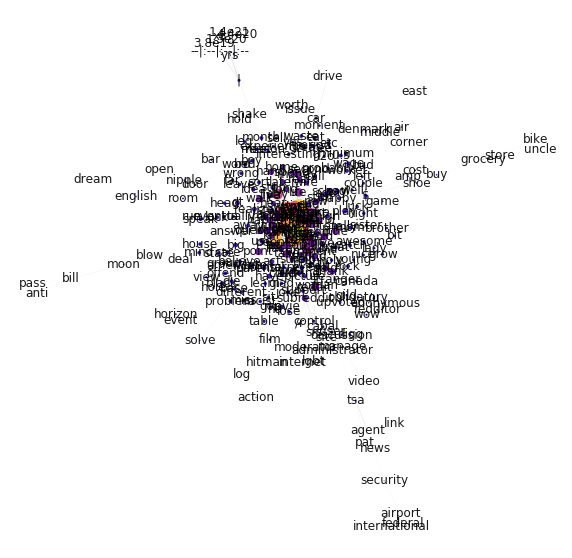

In [76]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

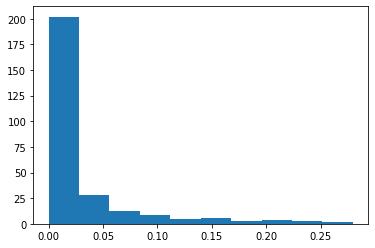

In [77]:
plt.hist(list(centralities.values()))
plt.show()

In [78]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('like', 0.27963883825707364),
 ('time', 0.25775190679134935),
 ('people', 0.245393342725652),
 ('know', 0.22779568303185163),
 ('go', 0.22654103059536645),
 ('think', 0.22067719836079452),
 ('get', 0.20295833959749018),
 ('m', 0.19969398864034624),
 ('good', 0.19887939498160204),
 ('thing', 0.17743002921323547)]

In [79]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('dream', 1.664227919203243e-05),
 ('bill', 1.4392126646013205e-05),
 ('link', 8.438266338539977e-06),
 ('international', 1.9566207697408314e-06),
 ('federal', 1.9566207697408314e-06),
 ('airport', 1.9566207697408314e-06),
 ('uncle', 9.89583519139916e-07),
 ('bike', 9.89583519139916e-07),
 ('pass', 5.861050790238528e-07),
 ('anti', 5.861050790238528e-07)]

In [80]:
def filterWords(G, minWeight = 3, filter_ = "closeness", rule = "number", value_of_rule = 200):
    """Function to filter network by degree centrality measures"""
    G = G.copy()
    try:
        G.remove_edges_from([(n1,n2) for n1, n2, d in G.edges(data = True) if d['weight'] < minWeight])
    except:
        print("weight might be missing from one or more edges")
        raise
    if filter_ =="betweenness":
        index = nx.betweenness_centrality(G) #betweeness centrality score
    elif filter_ == "closeness":
        index = nx.closeness_centrality(G) #closeness centrality score
    elif filter_ == "eigenvector":
        index = nx.eigenvector_centrality(G) #eigenvector centrality score
    elif filter_ == "degree":
        index = nx.degree_centrality(G) #degree centrality score
    else:
        raise ValueError("wrong filter paremeter, should be: betweenness/closeness/eigenvector")    
        
    if rule=='number':# if filter by limiting the total number of nodes 
        
        sorted_index = sorted(index.items(), key=lambda x:x[1], reverse=True)
        value_of_rule = np.min([value_of_rule, len(G.nodes)])
        
        nodes_remain = {}
        for word, centr in sorted_index[:value_of_rule]:
            nodes_remain[word] = centr
        G.remove_nodes_from([n for n in index if n not in nodes_remain])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G
    
    if rule=='above':# if filter by limiting the min value of centrality
        value_of_rule = np.max([float(value_of_rule),0])
        G.remove_nodes_from([n for n in index if index[n] >=value_of_rule])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G
    
    if rule=='below':# if filter by limiting the max value of centrality
        value_of_rule = np.max([float(value_of_rule),0])
        G.remove_nodes_from([n for n in index if index[n] <=value_of_rule])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G

In [81]:
giant_filtered30 = filterWords(giant, minWeight=3, filter_='closeness', rule='number', value_of_rule=25)
print(nx.info(giant_filtered30))

Total number of nodes(after filtering) in the graph is 25
Name: 
Type: Graph
Number of nodes: 25
Number of edges: 243
Average degree:  19.4400


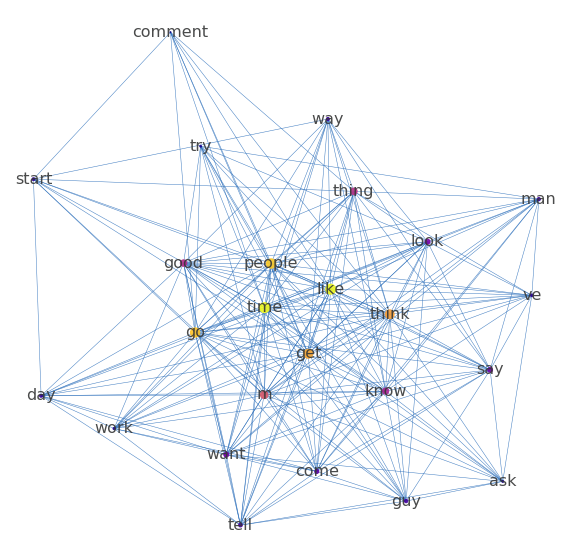

In [82]:
layout_giant_filtered30 = nx.spring_layout(giant_filtered30, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_giant30 = nx.betweenness_centrality(giant_filtered30)
maxC = max(centralities_giant30.items(), key = lambda x : x[1])[1]
nx.draw(giant_filtered30, ax = ax, pos = layout_giant_filtered30, labels = {n: n for n in giant_filtered30.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [centralities_giant30[n] / maxC for n in giant_filtered30.nodes],
        node_size = [centralities_giant30[n] / maxC * 100 for n in giant_filtered30.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

In [83]:
nx.density(giant)

0.025133017833747762

In [84]:
np.mean([v for w,v in nx.degree(giant)])

6.861313868613139

In [85]:
nx.diameter(giant)

9

The most central words tend to be the same among different methods. They are almost the same as the core cliques we found in Exercise 1 - like, people, go, know, good, think, want... Theses are words around people-related actions and events and are used to express opinions. Interestingly, the least central words using betweenness centrality include job, school, girl, black, control. The least central words produced by closeness centrality and eigenvector centrality are also quite interesting. Top words include bill, international, federal, airport, pass, and anti. From the plots, we can observe that the latter two methods captured the most meaningfull centrality in our dataset. Instead of solely focusing on the most central words, the least central words provide more information about what people tend not to discuss in the community.

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that construct at least two different networks comprising different combinations of word types, linked by different syntactic structures, which illuminate your corpus and the dynamics you are interested to explore. Graph these networks or subnetworks within them. What are relationships that are meaningful? 

<span style="color:red">***Stretch***: Graph some word-centered "ego-networks" with words one link away, two links away, and three links away (we only did up to two links away above).

In [86]:
import spacy
nlp = spacy.load('en')

In [87]:
def posCooccurrence(sentences, *posType, makeMatrix = False):
    words = set()
    reducedSents = []
    #Only using the first kind of POS for each word
    wordsMap = {}
    for sent in sentences:
        s = [(w, t) for w, t in lucem_illud_2020.spacy_pos(sent) if t in posType]
        for w, t in s:
            if w not in wordsMap:
                wordsMap[w] = t
        reducedSent = [w for w, t in s]
        words |= set(reducedSent)
        reducedSents.append(reducedSent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in reducedSents:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        for w in g.nodes:
            g.nodes[w]['bipartite'] = wordsMap[w]
        return g

In [101]:
gNN = posCooccurrence(commentsPosDF['normalized_sents'].sum(), 'NN')

In [89]:
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 5005
Number of edges: 35505
Average degree:  14.1878


In [102]:
gNN.remove_nodes_from([n for n in gNN.nodes if len(set(gNN.neighbors(n))) <= 150]) 
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 51
Number of edges: 801
Average degree:  31.4118


In [103]:
gNN.remove_edges_from([(n1, n2) for n1, n2, d in gNN.edges(data = True) if d['weight'] <= 5])
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 51
Number of edges: 75
Average degree:   2.9412


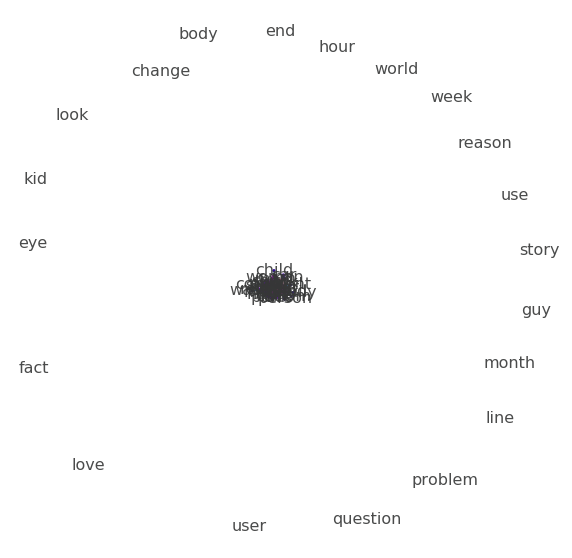

In [104]:
layout_nn = nx.spring_layout(gNN, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nn = nx.eigenvector_centrality(gNN)
maxC = max(centralities_nn.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNN.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNN.edges(data = True)))
nx.draw(gNN, ax = ax, pos = layout_nn, labels = {n: n for n in gNN.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nn[n] / maxC for n in gNN.nodes],
        node_size = [centralities_nn[n] / maxC * 100 for n in gNN.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

### Noun-Verb Network

In [114]:
gNV = posCooccurrence(commentsPosDF['normalized_sents'].sum(), 'NN', 'VB')

In [115]:
print(nx.info(gNV))

Name: 
Type: Graph
Number of nodes: 5278
Number of edges: 51750
Average degree:  19.6097


In [116]:
gNV.remove_edges_from([(n1,n2) for n1,n2,d in gNV.edges(data = True) if gNV.nodes[n1]['bipartite'] == gNV.nodes[n2]['bipartite']])

In [117]:
print(nx.info(gNV))

Name: 
Type: Graph
Number of nodes: 5278
Number of edges: 15601
Average degree:   5.9117


In [118]:
gNV.remove_edges_from([(n1, n2) for n1, n2, d in gNV.edges(data = True) if d['weight'] <= 5])
gNV.remove_nodes_from([n for n in gNV.nodes if len(set(gNV.neighbors(n))) <= 4])

In [119]:
print(nx.info(gNV))

Name: 
Type: Graph
Number of nodes: 13
Number of edges: 26
Average degree:   4.0000


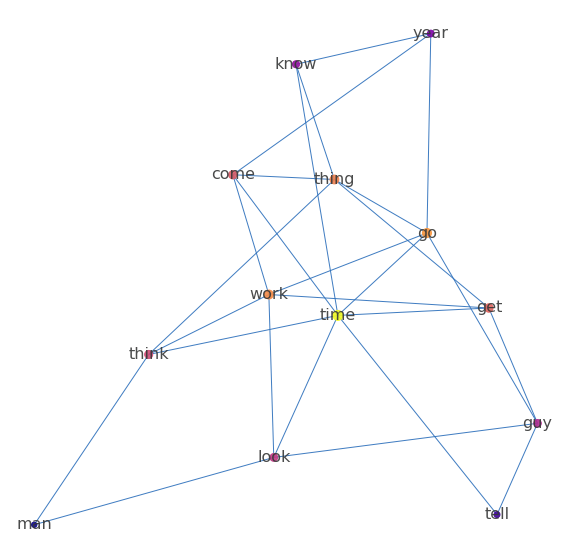

In [120]:
layout_nn = nx.spring_layout(gNV, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nv = nx.eigenvector_centrality(gNV)
maxC = max(centralities_nv.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNV.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNV.edges(data = True)))
nx.draw(gNV, ax = ax, pos = layout_nn, labels = {n: n for n in gNV.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nv[n] / maxC for n in gNV.nodes],
        node_size = [centralities_nv[n] / maxC * 100 for n in gNV.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       ) 

In [121]:
g_i = gNV.subgraph(['time'] + list(gNV.neighbors('time')))

In [122]:
print(nx.info(g_i))

Name: 
Type: Graph
Number of nodes: 8
Number of edges: 7
Average degree:   1.7500


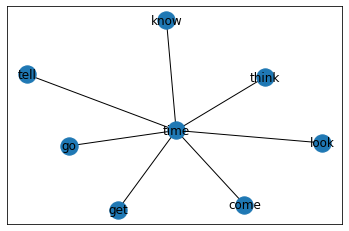

In [123]:
nx.draw_networkx(g_i)

In [134]:
storyNeighbors = gNV.neighbors('work')
set(storyNeighbors)

{'come', 'get', 'go', 'look', 'think'}

In [135]:
storyNeighbors = set(gNV.neighbors('think'))
storyNeighborsPlus1 = set(storyNeighbors)
for n in storyNeighbors:
    storyNeighborsPlus1 |= set(gNV.neighbors(n))

In [136]:
gNV_story = gNV.subgraph(storyNeighborsPlus1)
print(nx.info(gNV_story))

Name: 
Type: Graph
Number of nodes: 11
Number of edges: 19
Average degree:   3.4545


In [137]:
sorted(nx.degree_centrality(gNV_story).items(), key = lambda x: x[1], reverse = True)[:10]

[('time', 0.7000000000000001),
 ('thing', 0.5),
 ('work', 0.5),
 ('think', 0.4),
 ('go', 0.30000000000000004),
 ('get', 0.30000000000000004),
 ('look', 0.30000000000000004),
 ('come', 0.30000000000000004),
 ('man', 0.2),
 ('know', 0.2)]

In [138]:
sorted(nx.eigenvector_centrality(gNV_story).items(), key = lambda x: x[1], reverse = True)[:10]

[('time', 0.4544319435776822),
 ('work', 0.37368176284640187),
 ('thing', 0.3637355809158164),
 ('think', 0.3372039529688867),
 ('go', 0.3002246175203484),
 ('get', 0.3002246175203484),
 ('come', 0.3002246175203484),
 ('look', 0.24557963767452567),
 ('know', 0.20609487633084522),
 ('man', 0.1468027292672114)]

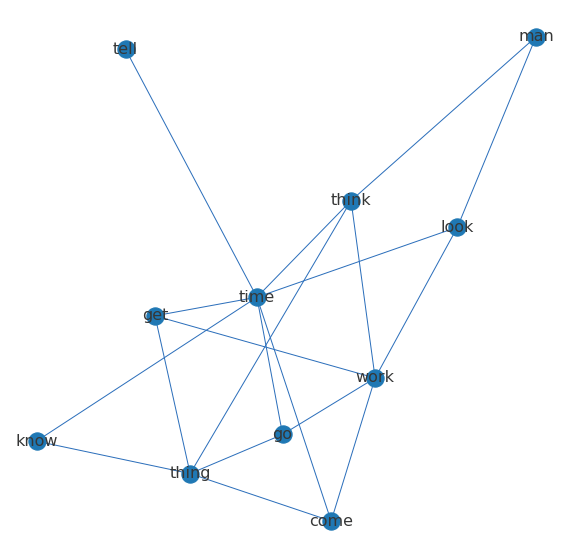

In [139]:
layout_story = nx.spring_layout(gNV_story, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(gNV_story, ax = ax, pos = layout_story, labels = {n: n for n in gNV_story.nodes()},
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
       ) 

In [140]:
storyNeighborsPlus2 = set(storyNeighborsPlus1)
for n in storyNeighborsPlus1:
    storyNeighborsPlus2 |= set(gNV.neighbors(n))

In [141]:
gNV_story = gNV.subgraph(storyNeighborsPlus2)
print(nx.info(gNV_story))

Name: 
Type: Graph
Number of nodes: 13
Number of edges: 26
Average degree:   4.0000


In [142]:
sorted(nx.degree_centrality(gNV_story).items(), key = lambda x: x[1], reverse = True)[:10]

[('time', 0.5833333333333333),
 ('thing', 0.41666666666666663),
 ('go', 0.41666666666666663),
 ('work', 0.41666666666666663),
 ('think', 0.3333333333333333),
 ('get', 0.3333333333333333),
 ('guy', 0.3333333333333333),
 ('look', 0.3333333333333333),
 ('come', 0.3333333333333333),
 ('year', 0.25)]

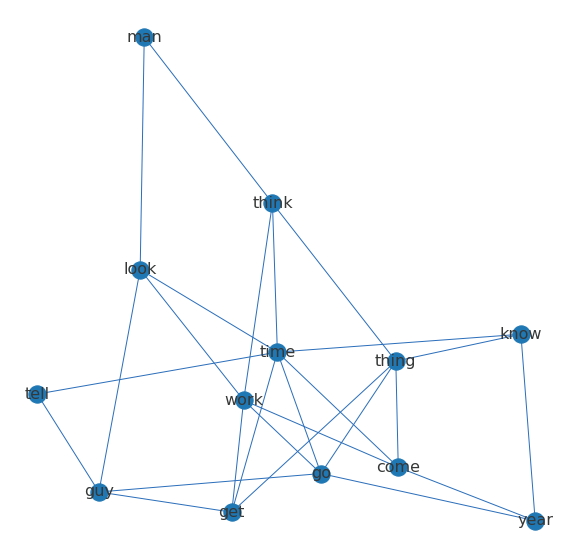

In [143]:
layout_story = nx.spring_layout(gNV_story, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(gNV_story, ax = ax, pos = layout_story, labels = {n: n for n in gNV_story.nodes()},
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
       ) 

### Noun-Adj Network

In [148]:
gNJ = posCooccurrence(commentsPosDF['normalized_sents'][:100].sum(), 'NN', 'JJ')
print(nx.info(gNJ))

Name: 
Type: Graph
Number of nodes: 528
Number of edges: 1396
Average degree:   5.2879


In [149]:
gNJ_filtered200 = filterWords(gNJ, minWeight=2, filter_='betweenness', rule='number', value_of_rule=25)
print(nx.info(gNJ_filtered200))

Total number of nodes(after filtering) in the graph is 25
Name: 
Type: Graph
Number of nodes: 25
Number of edges: 22
Average degree:   1.7600


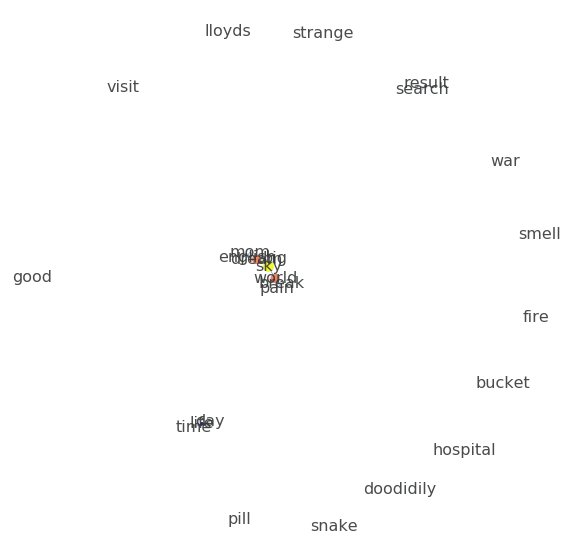

In [150]:
layout_NJ_filtered200 = nx.spring_layout(gNJ_filtered200, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nj200 = nx.betweenness_centrality(gNJ_filtered200)
maxC = max(centralities_nj200.items(), key = lambda x : x[1])[1]
nx.draw(gNJ_filtered200, ax = ax, pos = layout_NJ_filtered200, labels = {n: n for n in gNJ_filtered200.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [centralities_nj200[n] / maxC for n in gNJ_filtered200.nodes],
        node_size = [centralities_nj200[n] / maxC * 100 for n in gNJ_filtered200.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

In [166]:
storyNeighbors = gNJ_filtered200.neighbors('world')
set(storyNeighbors)

{'break', 'pain', 'sky', 'world'}

In [167]:
storyNeighbors = set(gNJ_filtered200.neighbors('world'))
storyNeighborsPlus1 = set(storyNeighbors)
for n in storyNeighbors:
    storyNeighborsPlus1 |= set(gNJ_filtered200.neighbors(n))

In [168]:
gNJ_story = gNJ_filtered200.subgraph(storyNeighborsPlus1)
print(nx.info(gNJ_story))

Name: 
Type: Graph
Number of nodes: 6
Number of edges: 9
Average degree:   3.0000


In [170]:
sorted(nx.degree_centrality(gNJ_story).items(), key = lambda x: x[1], reverse = True)[:10]

[('world', 1.0),
 ('sky', 1.0),
 ('big', 0.6000000000000001),
 ('break', 0.4),
 ('pain', 0.4),
 ('dream', 0.2)]

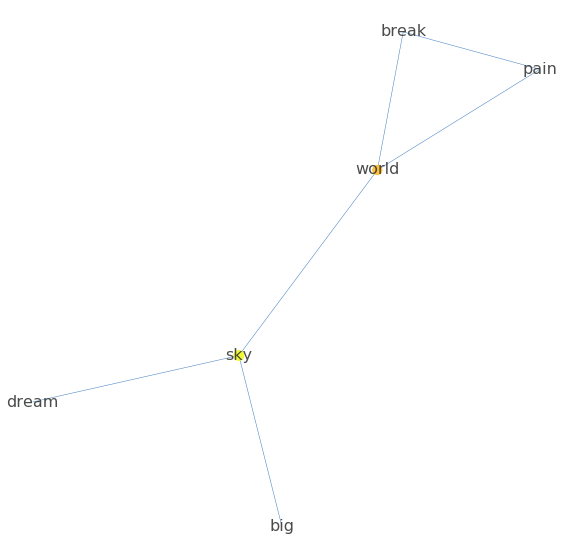

In [173]:
layout_NJ = nx.spring_layout(gNJ_story, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities = nx.betweenness_centrality(gNJ_story)
maxC = max(centralities.items(), key = lambda x : x[1])[1]
nx.draw(gNJ_story, ax = ax, pos = layout_NJ, labels = {n: n for n in gNJ_story.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [centralities[n] / maxC for n in gNJ_story.nodes],
        node_size = [centralities[n] / maxC * 100 for n in gNJ_story.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

The nodes in Noun-Verb networks are pretty similar to what we found in previous exercises. The most central cores are these words that are related to people and are intended to express opinions. The filtered Noun-Adj graph is really interesting. The core two nodes: sky and world, have very different subnetworks. The words related to world are quite negative in sentiment while those related to sky have very positive sentiment. It is interesting to see that the two nodes are connected in this way.

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">Construct cells immediately below this that perform a similar social similarity or influence analysis on a dataset relevant to your final project. Create relationships between actors in a network based on your dataset (e.g., person to person or document to document), and perform analyses that interrogate the structure of their interactions, similarity, and/or influence on one another. (For example, if relevant to your final project, you could explore different soap operas, counting how many times a character may have used the word love in conversation with another character, and identify if characters in love speak like each other. Or do opposites attract?) What does that analysis and its output reveal about the relative influence of each actor on others? What does it reveal about the social game being played?

<span style="color:red">Stretch 1:
Render the social network with weights (e.g., based on the number of scenes in which actors appear together), then calculate the most central actors in the show.Realtime output can be viewed in shell.

<span style="color:red">Stretch 2:
Implement more complex measures of similarity based on the papers you have read.

In [244]:
social_relationship = ['mom', 'dad', 'I', 'you', 'stranger', 'friend', 'family', 'partner']

In [245]:
rel = []
text = []
for row in commentsPosDF['tokenized_sents']:
    for each in row:
        for n in social_relationship:
            if n in each:
                rel.append(n)
                text.append(each)
relationship_df = pandas.DataFrame({'Relationship': rel, 'Tokenized Texts': text})
relationship_df.head()

,Relationship,Tokenized Texts
0,I,"[It, 's, a, shoebox, or, at, least, once, was,..."
1,I,"[I, 've, had, it, for, two, or, three, years]"
2,I,"[now, I, think, so, it, has, a, fair, amount, ..."
3,I,"[It, smells, atrocious, and, I, tried, to, bur..."
4,I,"[When, I, lit, it, on, fire, it, was, too, dam..."


In [246]:
relationship_df.groupby('Relationship').agg('count')

,Tokenized Texts
Relationship,
I,4464
dad,52
family,65
friend,86
mom,90
partner,6
stranger,49
you,2263


In [247]:
relationship_network = nx.Graph()
relationship_network.add_node('I', lines_spoken=4464, words=[])
relationship_network.add_node('dad', lines_spoken=52, words=[])
relationship_network.add_node('family', lines_spoken=65, words=[])
relationship_network.add_node('friend', lines_spoken=86, words=[])
relationship_network.add_node('mom', lines_spoken=90, words=[])
relationship_network.add_node('partner', lines_spoken=6, words=[])
relationship_network.add_node('stranger', lines_spoken=49, words=[])
relationship_network.add_node('you', lines_spoken=2263, words=[])

In [248]:
relationship_network.nodes.data()

NodeDataView({'I': {'lines_spoken': 4464, 'words': []}, 'dad': {'lines_spoken': 52, 'words': []}, 'family': {'lines_spoken': 65, 'words': []}, 'friend': {'lines_spoken': 86, 'words': []}, 'mom': {'lines_spoken': 90, 'words': []}, 'partner': {'lines_spoken': 6, 'words': []}, 'stranger': {'lines_spoken': 49, 'words': []}, 'you': {'lines_spoken': 2263, 'words': []}})

In [249]:
i = 0
for token in relationship_df['Tokenized Texts']:
    i += 1
    if i > len(relationship_df['Tokenized Texts']):
        break
    if token[0] in relationship_network.nodes():
        j = i
        for token_ in relationship_df['Tokenized Texts'][i:]:
            if token_[0] in set(social_relationship):
                # if both the characters exist in the graph, add a weight
                if token[0] != token_[0] and token_[0] in relationship_network.nodes():
                    if (token[0], token_[0]) not in relationship_network.edges():
                        relationship_network.add_edge(token[0], token_[0], weight=0)
                    if (token[0], token_[0]) in relationship_network.edges():
                        relationship_network.edges[(token[0], token_[0])]['weight'] += 1
                break
            j += 1
        # adding characters sentences
        relationship_network.nodes[token[0]]['words'].append(relationship_df['Tokenized Texts'][i:j])

In [250]:
relationship_network.edges.data()

EdgeDataView([('I', 'you', {'weight': 150})])

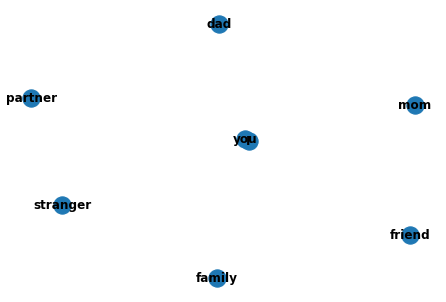

In [251]:
nx.draw(relationship_network, with_labels=True, font_weight='bold')

We were not able to generate a social network with weights in our dataset. The only edge we get is between "I" and "you", which occurs 150 times in our dataset. This is possibly due to the nature of comments, in which we use different words in colloquial expressions to address different parties - e.g. "I talked to him" instead of "I talked to he". Most comments may only involve one character - "I", "he", "she", "you", "my mom", etc... But still, it is surprising that we only generate one connection ("I"-"you") in these 5000 comments.

In future analysis, we may include more social roles and expressions into our analysis - e.g. "his", "her",  "siblings", "girlfriend/boyfriend", "relative", "teacher", etc... However, our social network won't be as meaningful as those generated by character's lines in movies. Instead, we can focus more on analyzing the structure of words and the central nodes in our dataset.